In [3]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import sys
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import glob
# np행렬 생략 부분 출력 펼쳐서 보기 옵션
np.set_printoptions(threshold=np.inf, linewidth=np.inf)
import os, re, glob
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

In [4]:
# 우리가 만든 데이터셋 불러오기.
train_X, test_X, train_Y, test_Y = np.load('/content/drive/My Drive/Colab Notebooks/데이터/images_data_set.npy',allow_pickle=True)
train_X.shape, test_X.shape, train_Y.shape, test_Y.shape

((4824, 28, 28, 3), (1608, 28, 28, 3), (4824,), (1608,))

In [5]:
# train_X, test_X 그레이스케일 통과후 리스트에 담아주기.
gray_train_X_list = []
for idx, img in enumerate(train_X):
    gray_train_X_list.append(cv2.cvtColor(img, cv2.COLOR_BGRA2GRAY))

gray_test_X_list = []
for idx, img in enumerate(test_X):
    gray_test_X_list.append(cv2.cvtColor(img, cv2.COLOR_BGRA2GRAY))

In [6]:
# 리스트의 첫번째 이미지를 새로운 변수에 할당
new_train_X = gray_train_X_list[0]
new_train_X = new_train_X.reshape(1,28,28)

new_test_X = gray_test_X_list[0]
new_test_X = new_test_X.reshape(1,28,28)

print(new_train_X.shape, new_test_X.shape)

(1, 28, 28) (1, 28, 28)


In [7]:
# for문을 돌면서 새로운 변수에 추가 해주고, 기존 변수명으로 변경
for train_X_img in gray_train_X_list[1:]:
    new_train_X = np.vstack((new_train_X, train_X_img.reshape(1,28,28)))

for test_X_img in gray_test_X_list[1:]:
    new_test_X = np.vstack((new_test_X, test_X_img.reshape(1,28,28)))

train_X = new_train_X
test_X = new_test_X

print(train_X.shape, test_X.shape, train_Y.shape, test_Y.shape)

(4824, 28, 28) (1608, 28, 28) (4824,) (1608,)


In [8]:
# 밑에 vggnet 모방 코드 사용 하려면 여기 셀 실행 해야함/ input 을 맞춰주기 위함.

print(train_X.shape, test_X.shape)
# (미니배치크기, 입력이미지행수, 입력이미지열수, 입력이미지체널수)
train_X = train_X.reshape(-1, 28, 28, 1)
test_X = test_X.reshape(-1, 28, 28, 1)
print(train_X.shape, test_X.shape)

(4824, 28, 28) (1608, 28, 28)
(4824, 28, 28, 1) (1608, 28, 28, 1)


In [ ]:
# 이미지 보강??
image_generator = ImageDataGenerator(
    rotation_range = 10,
    zoom_range = 0.10,
    shear_range = 0.5,
    width_shift_range = 0.10,
    height_shift_range = 0.10,
    horizontal_flip = True,
    vertical_flip = False)

augment_size = 2000

In [ ]:
# 원본 이미지 무작위 선택 및 데이터 복사
x_choice = np.random.choice(train_X.shape[0], size = augment_size, replace=False)
x_augmented = train_X[x_choice].copy()
y_augmented = train_Y[x_choice].copy()
# 보강 이미지 데이터 생성
x_augmented = image_generator.flow(x_augmented, np.zeros(augment_size),batch_size = augment_size, shuffle = False).next()[0]  

In [ ]:
x_augmented_1 = image_generator.flow(x = x_augmented, 
                                 y = np.zeros(augment_size),
                                 batch_size = augment_size,  
                                 shuffle = False).next()[1]   

In [ ]:
print(x_augmented.shape)
print(x_augmented_1.shape)

(2000, 28, 28, 1)
(2000,)


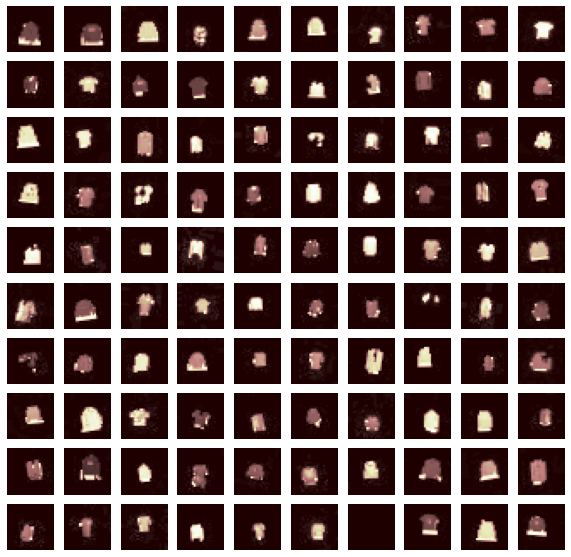

In [ ]:
#보강 이미지 확인
plt.figure(figsize=(10,10))
for i in range(100):
  plt.subplot(10,10,i+1)
  plt.axis('off')
  plt.imshow(x_augmented[i].reshape(28,28), cmap='pink')
plt.show()

In [ ]:
#데이터 합쳐주기
train_X = np.concatenate((train_X,x_augmented))
train_Y = np.concatenate((train_Y,y_augmented))

In [ ]:
#보강 데이터 결합 확인
print(train_X.shape, train_Y.shape)

(4619, 28, 28, 1) (4619,)


In [9]:
train_X = train_X / 255.0
test_X = test_X / 255.0
# print(train_X[2])

In [ ]:
# 다층 퍼셉트론
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = (28,28)),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=4, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 516       
Total params: 100,996
Trainable params: 100,996
Non-trainable params: 0
_________________________________________________________________


In [131]:
# vggnet 모방 모델
model= tf.keras.Sequential([
    tf.keras.layers.Conv2D(input_shape=(28,28,1),kernel_size=(3,3),filters=32,padding='same',activation='relu'),
    tf.keras.layers.Conv2D(input_shape=(28,28,1),kernel_size=(3,3),filters=64,padding='same',activation='relu'),
    tf.keras.layers.MaxPool2D(strides = (2,2)),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Conv2D(kernel_size=(3,3),filters = 128, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=(3,3),filters = 256, padding = 'valid', activation='relu'),
    tf.keras.layers.MaxPool2D(strides = (2,2)),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation = 'relu'),
    tf.keras.layers.Dropout(rate = 0.3),
    tf.keras.layers.Dense(units=256, activation = 'relu'),
    tf.keras.layers.Dropout(rate = 0.3),
    tf.keras.layers.Dense(units=4, activation = 'softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 12, 12, 256)       295168    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 6, 6, 256)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 9216)             

In [132]:
history = model.fit(train_X, train_Y, epochs=500, validation_split=0.25,
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=20, monitor='val_loss')])

Epoch 1/500
114/114 [==============================] - 1s 9ms/step - loss: 0.5770 - accuracy: 0.7637 - val_loss: 0.3523 - val_accuracy: 0.8615
Epoch 2/500
114/114 [==============================] - 1s 7ms/step - loss: 0.2259 - accuracy: 0.9182 - val_loss: 0.1762 - val_accuracy: 0.9353
Epoch 3/500
114/114 [==============================] - 1s 7ms/step - loss: 0.1728 - accuracy: 0.9409 - val_loss: 0.2686 - val_accuracy: 0.8939
Epoch 4/500
114/114 [==============================] - 1s 7ms/step - loss: 0.1177 - accuracy: 0.9585 - val_loss: 0.1778 - val_accuracy: 0.9395
Epoch 5/500
114/114 [==============================] - 1s 7ms/step - loss: 0.0937 - accuracy: 0.9690 - val_loss: 0.1730 - val_accuracy: 0.9436
Epoch 6/500
114/114 [==============================] - 1s 7ms/step - loss: 0.0803 - accuracy: 0.9729 - val_loss: 0.1613 - val_accuracy: 0.9378
Epoch 7/500
114/114 [==============================] - 1s 7ms/step - loss: 0.0653 - accuracy: 0.9746 - val_loss: 0.1603 - val_accuracy: 0.9544

In [126]:
# GPU메모리 증가 허용하기 코드..내가 알아야할 필요가 있을지..? 뭔 이야기인지는 모르겠음.
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
class fashion_tools(object):
    def __init__(self,imageid,model,version=1.1):
        self.imageid = imageid
        self.model   = model
        self.version = version
        
    def get_dress(self,stack=False):
        """limited to top wear and full body dresses (wild and studio working)"""
        """takes input rgb----> return PNG"""
        name =  self.imageid
        file = name
        # file = cv2.imread(name)
        file = tf.image.resize_with_pad(file,target_height=512,target_width=512)
        rgb  = file.numpy()
        file = np.expand_dims(file,axis=0)/ 255.
        seq = self.model.predict(file)
        seq = seq[3][0,:,:,0]
        seq = np.expand_dims(seq,axis=-1)
        c1x = rgb*seq
        c2x = rgb*(1-seq)
        cfx = c1x+c2x
        dummy = np.ones((rgb.shape[0],rgb.shape[1],1))
        rgbx = np.concatenate((rgb,dummy*255),axis=-1)
        rgbs = np.concatenate((cfx,seq*255.),axis=-1)
        if stack:
            stacked = np.hstack((rgbx,rgbs))
            return stacked
        else:
            return rgbs
        
    def get_patch(self):
        return None

    def development(self):
        n_ = '\n'
        return (f"VERSION : {self.version} {n_} Interesting tools to be added to the workflow pipe!!!")

# 이미지 패딩값 주는 코드
def resize_with_padding(img, expected_size):
    img.thumbnail((expected_size[0], expected_size[1]))
    # print(img.size)
    delta_width = expected_size[0] - img.size[0]
    delta_height = expected_size[1] - img.size[1]
    pad_width = delta_width // 2
    pad_height = delta_height // 2
    padding = (pad_width, pad_height, delta_width - pad_width, delta_height - pad_height)
    return ImageOps.expand(img, padding)

# 결과 값 이미지 자르기
def crop(image):
    image_crop = image[:,512:]
    image_crop = np.uint8(image_crop)
    return black(image_crop)

# 투명값 검정배경 입혀주기.
def black(image_crop):
    for i in image_crop:
        for j in i:
            if j[3] < 80:
                j[0] = 0
                j[1] = 0
                j[2] = 0
    image_black = image_crop
    # cv2_imshow(image_black)
    return resize(image_black)

# 리사이즈 인풋값 맞춰 주기.
def resize(image_black):
    image_resize = cv2.resize(image_black, (28,28))
    return gray(image_resize)

# 그레이 스케일.. 후 픽셀 출력..
def gray(image_resize):
    image_gray = cv2.cvtColor(image_resize, cv2.COLOR_BGRA2GRAY)
    return image_gray


if __name__ == "__main__":
    # sample_images_path = glob.glob("/content/drive/My Drive/Colab Notebooks/blazer_images_choice/*.jpg")
    # sample_image = cv2.imread('/content/예시.jpg')
    # 훈련된 모델 가지고 오는 경로 설정.
    saved = load_model("/content/drive/My Drive/Colab Notebooks/데이터/topwears.h5")

    # for idx, image_path in enumerate(sample_images_path):
        # try:
    img = Image.open("/content/후드티샘플4.jpg")
    img = resize_with_padding(img, (750, 750))
    img = np.array(img)

    ###running code
    api    = fashion_tools(img,saved)
    image = api.get_dress(True)
    result_image = crop(image)
    cv2_imshow(result_image)
            # # 파일저장.
            # cv2.imwrite(f'/content/drive/My Drive/Colab Notebooks/preprocessing_images/0/prepro_blazer_image{idx}.jpg', result_image)
            # if idx % 10 == 0:
            #     print(idx,'done')
        # except:
        #     pass

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1751: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [127]:
# 정규화 해준다.
input_image = result_image/255.0
input_image.shape
# input값이 3차원 이여서 차원을 늘려준다.
input_image = np.reshape(input_image, (1,28,28,1))
input_image.shape

(1, 28, 28, 1)

In [14]:
test_X[[2]].shape

(1, 28, 28, 1)

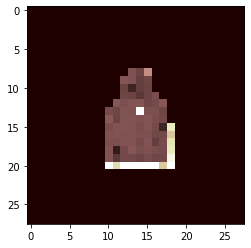

[[1.0008206 1.0158608 1.0295036 1.953815 ]]


In [128]:
#예측 수행
input_predict = model.predict(input_image)+1
#예측 이미지 확인 
plt.imshow(input_image.reshape(28,28), cmap = 'pink')
plt.show()

#예측 결과 확인
print(input_predict)

# 0 : 후드티 , 1 : 맨투맨, 2 : 셔츠, 3 : 티셔츠